# Loopless FBA

The goal of this procedure is identification of a thermodynamically consistent flux state without loops, as implied by the name.

Usually, the model has the following constraints.
$$ S \cdot v = 0 $$
$$ lb \le v \le ub $$

However, this will allow for thermodynamically infeasible loops (referred to as type 3 loops) to occur, where flux flows around a cycle without any net change of metabolites. For most cases, this is not a major issue, as solutions with these loops can usually be converted to equivalent solutions without them. However, if a flux state is desired which does not exhibit any of these loops, loopless FBA can be used. The formulation used here is modified from [Schellenberger et al.](http://dx.doi.org/10.1016/j.bpj.2010.12.3707)

We can make the model irreversible, so that all reactions will satisfy
$$ 0 \le lb \le v \le ub \le \max(ub) $$

We will add in boolean indicators as well, such that
$$ \max(ub) \cdot i \ge v $$
$$ i \in \{0, 1\} $$

We also want to ensure that an entry in the row space of S also exists with negative values wherever v is nonzero. In this expression, $1-i$ acts as a not to indicate inactivity of a reaction.

$$ S^\mathsf T x - (1 - i) (\max(ub) + 1) \le -1 $$

We will construct an LP integrating both constraints.

$$ \left(
\begin{matrix}
S & 0 & 0\\
-I & \max(ub)I & 0 \\
0 & (\max(ub) + 1)I & S^\mathsf T
\end{matrix}
\right)
\cdot
\left(
\begin{matrix}
v \\
i \\
x
\end{matrix}
\right)
\begin{matrix}
&=& 0 \\
&\ge& 0 \\
&\le& \max(ub)
\end{matrix}$$

Note that these extra constraints are not applied to boundary reactions which bring metabolites in and out of the system.

In [1]:
from matplotlib.pylab import *
%matplotlib inline

import cobra.test
from cobra import Reaction, Metabolite, Model
from cobra.flux_analysis.loopless import construct_loopless_model
from cobra.solvers import get_solver_name

We will demonstrate with a toy model which has a simple loop cycling A -> B -> C -> A, with A allowed to enter the system and C allowed to leave. A graphical view of the system is drawn below:

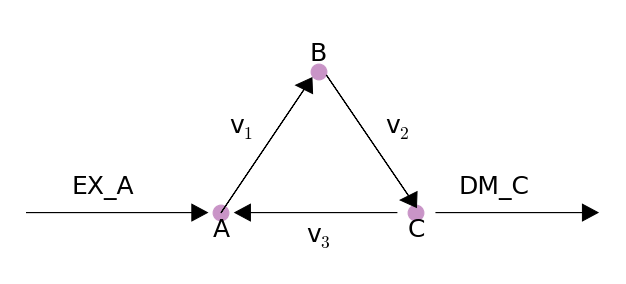

In [2]:
figure(figsize=(10.5, 4.5), frameon=False)
gca().axis("off")
xlim(0.5, 3.5)
ylim(0.7, 2.2)
arrow_params = {"head_length": 0.08, "head_width": 0.1, "ec": "k", "fc": "k"}
text_params = {"fontsize": 25, "horizontalalignment": "center", "verticalalignment": "center"}
arrow(0.5, 1, 0.85, 0, **arrow_params)  # EX_A
arrow(1.5, 1, 0.425, 0.736, **arrow_params)  # v1
arrow(2.04, 1.82, 0.42, -0.72, **arrow_params)  # v2
arrow(2.4, 1, -0.75, 0, **arrow_params)  # v3
arrow(2.6, 1, 0.75, 0, **arrow_params)
# reaction labels
text(0.9, 1.15, "EX_A", **text_params)
text(1.6, 1.5, r"v$_1$", **text_params)
text(2.4, 1.5, r"v$_2$", **text_params)
text(2, 0.85, r"v$_3$", **text_params)
text(2.9, 1.15, "DM_C", **text_params)
# metabolite labels
scatter(1.5, 1, s=250, color='#c994c7')
text(1.5, 0.9, "A", **text_params)
scatter(2, 1.84, s=250, color='#c994c7')
text(2, 1.95, "B", **text_params)
scatter(2.5, 1, s=250, color='#c994c7')
text(2.5, 0.9, "C", **text_params);

In [3]:
test_model = Model()
test_model.add_metabolites(Metabolite("A"))
test_model.add_metabolites(Metabolite("B"))
test_model.add_metabolites(Metabolite("C"))
EX_A = Reaction("EX_A")
EX_A.add_metabolites({test_model.metabolites.A: 1})
DM_C = Reaction("DM_C")
DM_C.add_metabolites({test_model.metabolites.C: -1})
v1 = Reaction("v1")
v1.add_metabolites({test_model.metabolites.A: -1, test_model.metabolites.B: 1})
v2 = Reaction("v2")
v2.add_metabolites({test_model.metabolites.B: -1, test_model.metabolites.C: 1})
v3 = Reaction("v3")
v3.add_metabolites({test_model.metabolites.C: -1, test_model.metabolites.A: 1})
DM_C.objective_coefficient = 1
test_model.add_reactions([EX_A, DM_C, v1, v2, v3])

While this model contains a loop, a flux state exists which has no flux through reaction v3, and is identified by loopless FBA.

In [4]:
construct_loopless_model(test_model).optimize()

<Solution 1000.00 at 0x7f003ad82850>

However, if flux is forced through v3, then there is no longer a feasible loopless solution.

In [5]:
v3.lower_bound = 1
construct_loopless_model(test_model).optimize()

<Solution 'infeasible' at 0x7f003ad82f10>

Loopless FBA is also possible on genome scale models, but it requires a capable MILP solver.

In [6]:
salmonella = cobra.test.create_test_model("salmonella")
construct_loopless_model(salmonella).optimize(solver=get_solver_name(mip=True))

<Solution 0.38 at 0x7f003a496190>

In [7]:
ecoli = cobra.test.create_test_model("ecoli")
construct_loopless_model(ecoli).optimize(solver=get_solver_name(mip=True))

<Solution 0.98 at 0x7f003ae06b50>